# Background
This notebook uses the [GitHub GraphQL API](https://developer.github.com/v4/) to report Kubeflow **open PRs** whcih needs attention according to:
* The time interval they have been open,  
* Last time they have been edited or updated.

It then list the following PRs:
* PRs whcih need autors' attention
* PRs which need editors' attention
* PRs whhch have been quiet for over a week
* PRs whcih have been open for over a mounth

# Github Setup
You will need a GitHub personal access token in order to use the GitHub API
* See these [instructions](https://help.github.com/en/articles/creating-a-personal-access-token-for-the-command-line) for creating a personal access token
* Set the environment variable GITHUB_TOKEN to pass your token to the code


In [89]:
import argparse
import datetime
from dateutil import parser as date_parser
import json
import logging
import numpy as np
import os
import pandas as pd
import pprint
import requests
from pandas.io.json import json_normalize 


In [57]:
query_template="""{{
  search(query: "org:kubeflow is:pr is:open created:>2019-01-01", type: ISSUE, first: 100, {cursor}) {{
    edges {{
      node {{
        ... on PullRequest {{
          title
                    url
                    number
                    createdAt
                    lastEditedAt
                    updatedAt
                    editor {{
                      login
                    }}
                    author {{
                      login
                    }}
        }}
      }}
     }}
     pageInfo {{
                    endCursor
                    hasNextPage
    }}
      
  }}
}}"""

In [58]:
os.environ["GITHUB_TOKEN"]="5ebfd24d8af0960ef9e2d118d62346f366410443"

In [59]:
headers = {"Authorization": "Bearer {0}".format(os.getenv("GITHUB_TOKEN"))}


In [60]:
search_cursor = None
hasNextPage = True
df = pd.DataFrame()
cursor_text = ""
pageno=0
while hasNextPage:
    print('getting data fo page ',pageno)
    if search_cursor:
          cursor_text = "after:\"{0}\"".format(search_cursor)
    query = query_template.format(cursor=cursor_text)
    request = requests.post('https://api.github.com/graphql', json={'query': query}, headers=headers)
    print('request code ',request.status_code)
    rtext=request.text
    rdict=json.loads(rtext)
    prnodes = rdict["data"]["search"]["edges"]
    search_cursor = rdict["data"]["search"]["pageInfo"]["endCursor"]
    hasNextPage = rdict["data"]["search"]["pageInfo"]["hasNextPage"]
    print('nomer of nodes found in this page', len(prnodes))
    rawdf = pd.DataFrame.from_dict(prnodes)[['node']]
    newdf = pd.DataFrame.from_records(rawdf['node'])  #decompose column node to multiple columns
    df  =  pd.concat([df,newdf])
    pageno = pageno +1    
    
     

('getting data fo page ', 0)
('request code ', 200)
('nomer of nodes found in this page', 100)
('getting data fo page ', 1)
('request code ', 200)
('nomer of nodes found in this page', 59)


In [61]:
df['createdAt'] = df['createdAt'].apply(lambda x: pd.Timestamp(x))
df['lastEditedAt'] = df['lastEditedAt'].apply(lambda x: pd.Timestamp(x))
df['updatedAt'] = df['updatedAt'].apply(lambda x: pd.Timestamp(x))

In [62]:
def getTimeDeltaFromNowH(x):
    td = pd.Timestamp.utcnow() - pd.Timestamp(x)
    days, hours, minutes = td.days, td.seconds // 3600, td.seconds % 3600 / 60.0
    return days*24 + hours
    

In [63]:
df['creationAge'] = df['createdAt'].apply(lambda x: getTimeDeltaFromNowH(x))
df['lastEditAge'] = df['lastEditedAt'].apply(lambda x: getTimeDeltaFromNowH(x))
df['updateAge'] = df['updatedAt'].apply(lambda x: getTimeDeltaFromNowH(x))


# Distribution of PRs' open time (age)

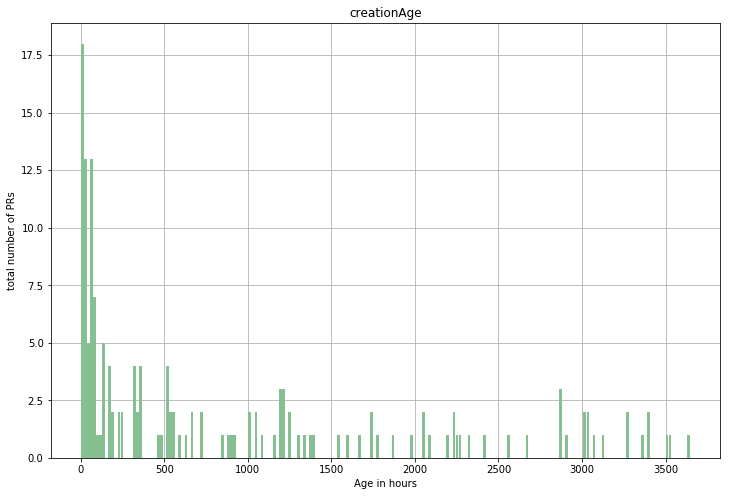

In [87]:
hist = df.hist(column='creationAge', bins=200,figsize=(12,8), color='#86bf91', zorder=2, rwidth=0.9)
ax = hist[0]
for x in ax:
    x.set_xlabel("Age in hours")
    x.set_ylabel("total number of PRs")

# PRs which need attention

A huristic solution is to list prs which have either of the following conditions:
* No activity is recoreded for the pr for a long time (i.e., both updateAge and lastEditedAge exceeds a threshold).
* Has been open for a long time (i.e., creationAge exceeds a threshold)
* Needs author's attention (i.e. it has been edited for a long time but has not been updated afterwards)
* Needs editor's attention (i.e., it has been updated for a long time but has not been edited afterwards)

In [74]:
MAX_AGE = 24*30
MAX_QUIET_TIME = 7*24

In [75]:
needs_attention = df[(df.creationAge > MAX_AGE) |
                     ((df.updateAge > MAX_QUIET_TIME) & (df.lastEditAge > MAX_QUIET_TIME*1.0)) |
                     ((df.updateAge > MAX_QUIET_TIME) &  (df.lastEditAge>df.updateAge*1.0)) |
                     ((df.lastEditAge > MAX_QUIET_TIME*1.0) & (df.lastEditAge < df.updateAge*1.0))
                    ]
needs_attention


,author,createdAt,editor,lastEditedAt,number,title,updatedAt,url,creationAge,lastEditAge,updateAge
68,{u'login': u'jeremiahkellick'},2019-05-29 15:53:23+00:00,{u'login': u'jlewi'},2019-05-29 15:53:29+00:00,108,Add jeremiahkellick to org.yaml,2019-05-29 16:56:10+00:00,https://github.com/kubeflow/internal-acls/pull...,197,197.0,196
70,{u'login': u'ggaaooppeenngg'},2019-05-28 04:23:09+00:00,{u'login': u'jlewi'},2019-05-28 04:23:14+00:00,20,support frozen model,2019-05-28 04:23:23+00:00,https://github.com/kubeflow/batch-predict/pull/20,233,233.0,233
74,{u'login': u'aakashbajaj'},2019-05-24 09:47:58+00:00,{u'login': u'jlewi'},2019-05-24 09:48:05+00:00,1384,gcp cred bug fix for multiple credentials in s...,2019-05-24 10:07:10+00:00,https://github.com/kubeflow/pipelines/pull/1384,323,323.0,323
75,{u'login': u'gyliu513'},2019-05-24 08:09:49+00:00,{u'login': u'jlewi'},2019-05-24 08:09:58+00:00,586,WIP Do not use /tmp/katib as host path.,2019-05-29 03:02:45+00:00,https://github.com/kubeflow/katib/pull/586,325,325.0,210
80,{u'login': u'M00nF1sh'},2019-05-22 23:28:30+00:00,{u'login': u'jlewi'},2019-05-22 23:28:36+00:00,3340,templatize istio k8s version for aws,2019-05-23 18:45:23+00:00,https://github.com/kubeflow/kubeflow/pull/3340,358,358.0,338
81,{u'login': u'M00nF1sh'},2019-05-22 22:32:49+00:00,{u'login': u'M00nF1sh'},2019-05-22 22:35:54+00:00,3337,Update OWNERS file and make ingress configurab...,2019-05-29 23:15:34+00:00,https://github.com/kubeflow/kubeflow/pull/3337,359,358.0,190
83,{u'login': u'kkasravi'},2019-05-18 14:47:09+00:00,{u'login': u'jlewi'},2019-05-18 14:47:14+00:00,3311,add kkasravi to OWNERS,2019-05-18 14:47:23+00:00,https://github.com/kubeflow/kubeflow/pull/3311,462,462.0,462
85,{u'login': u'elikatsis'},2019-05-16 13:49:06+00:00,{u'login': u'jlewi'},2019-05-16 13:49:17+00:00,3294,"Add verb ""create"" for Secrets to ClusterRole ""...",2019-05-16 21:06:24+00:00,https://github.com/kubeflow/kubeflow/pull/3294,511,511.0,504
86,{u'login': u'chenhan1218'},2019-05-16 10:17:15+00:00,{u'login': u'jlewi'},2019-05-16 10:17:21+00:00,3290,"fix #2863, postpone check kubeflow ready",2019-05-16 19:49:23+00:00,https://github.com/kubeflow/kubeflow/pull/3290,515,515.0,505
88,{u'login': u'ryandawsonuk'},2019-05-16 08:29:16+00:00,{u'login': u'ryandawsonuk'},2019-05-16 08:29:52+00:00,103,seldon org update,2019-05-16 08:29:52+00:00,https://github.com/kubeflow/internal-acls/pull...,517,517.0,517


# PRs which need authors' attentions 

In [76]:
needs_attention[(needs_attention.updateAge > MAX_QUIET_TIME) &  (needs_attention.lastEditAge>needs_attention.updateAge*1.0)]

,author,createdAt,editor,lastEditedAt,number,title,updatedAt,url,creationAge,lastEditAge,updateAge
68,{u'login': u'jeremiahkellick'},2019-05-29 15:53:23+00:00,{u'login': u'jlewi'},2019-05-29 15:53:29+00:00,108,Add jeremiahkellick to org.yaml,2019-05-29 16:56:10+00:00,https://github.com/kubeflow/internal-acls/pull...,197,197.0,196
75,{u'login': u'gyliu513'},2019-05-24 08:09:49+00:00,{u'login': u'jlewi'},2019-05-24 08:09:58+00:00,586,WIP Do not use /tmp/katib as host path.,2019-05-29 03:02:45+00:00,https://github.com/kubeflow/katib/pull/586,325,325.0,210
80,{u'login': u'M00nF1sh'},2019-05-22 23:28:30+00:00,{u'login': u'jlewi'},2019-05-22 23:28:36+00:00,3340,templatize istio k8s version for aws,2019-05-23 18:45:23+00:00,https://github.com/kubeflow/kubeflow/pull/3340,358,358.0,338
81,{u'login': u'M00nF1sh'},2019-05-22 22:32:49+00:00,{u'login': u'M00nF1sh'},2019-05-22 22:35:54+00:00,3337,Update OWNERS file and make ingress configurab...,2019-05-29 23:15:34+00:00,https://github.com/kubeflow/kubeflow/pull/3337,359,358.0,190
85,{u'login': u'elikatsis'},2019-05-16 13:49:06+00:00,{u'login': u'jlewi'},2019-05-16 13:49:17+00:00,3294,"Add verb ""create"" for Secrets to ClusterRole ""...",2019-05-16 21:06:24+00:00,https://github.com/kubeflow/kubeflow/pull/3294,511,511.0,504
86,{u'login': u'chenhan1218'},2019-05-16 10:17:15+00:00,{u'login': u'jlewi'},2019-05-16 10:17:21+00:00,3290,"fix #2863, postpone check kubeflow ready",2019-05-16 19:49:23+00:00,https://github.com/kubeflow/kubeflow/pull/3290,515,515.0,505
89,{u'login': u'yanniszark'},2019-05-15 17:43:21+00:00,{u'login': u'jlewi'},2019-05-15 17:43:27+00:00,3278,basic-auth: make kflogin work with NodePort,2019-05-18 17:53:55+00:00,https://github.com/kubeflow/kubeflow/pull/3278,531,531.0,459
90,{u'login': u'ryandawsonuk'},2019-05-15 17:18:21+00:00,{u'login': u'jlewi'},2019-05-15 17:18:32+00:00,269,add rd@seldon.io to member_organizations.yaml,2019-05-16 05:09:11+00:00,https://github.com/kubeflow/community/pull/269,532,532.0,520
93,{u'login': u'gaocegege'},2019-05-13 02:13:15+00:00,{u'login': u'jlewi'},2019-05-13 02:13:20+00:00,500,WIP feat(suggestion): Define new API for sugge...,2019-05-13 05:59:01+00:00,https://github.com/kubeflow/katib/pull/500,595,595.0,591
94,{u'login': u'achalshant'},2019-05-11 17:45:09+00:00,{u'login': u'jlewi'},2019-05-11 17:45:15+00:00,498,Decoupling DB interface from katib manager,2019-05-27 18:16:21+00:00,https://github.com/kubeflow/katib/pull/498,627,627.0,243


# PRs which need editors' attentions 

In [77]:
needs_attention[(needs_attention.lastEditAge > MAX_QUIET_TIME*1.0) &  (needs_attention.lastEditAge<needs_attention.updateAge*1.0)]

,author,createdAt,editor,lastEditedAt,number,title,updatedAt,url,creationAge,lastEditAge,updateAge


# PRs whcih have been quiet for over a week

In [78]:
needs_attention[(needs_attention.lastEditAge > MAX_QUIET_TIME*1.0) &  (needs_attention.updateAge > MAX_QUIET_TIME)]

,author,createdAt,editor,lastEditedAt,number,title,updatedAt,url,creationAge,lastEditAge,updateAge
68,{u'login': u'jeremiahkellick'},2019-05-29 15:53:23+00:00,{u'login': u'jlewi'},2019-05-29 15:53:29+00:00,108,Add jeremiahkellick to org.yaml,2019-05-29 16:56:10+00:00,https://github.com/kubeflow/internal-acls/pull...,197,197.0,196
70,{u'login': u'ggaaooppeenngg'},2019-05-28 04:23:09+00:00,{u'login': u'jlewi'},2019-05-28 04:23:14+00:00,20,support frozen model,2019-05-28 04:23:23+00:00,https://github.com/kubeflow/batch-predict/pull/20,233,233.0,233
74,{u'login': u'aakashbajaj'},2019-05-24 09:47:58+00:00,{u'login': u'jlewi'},2019-05-24 09:48:05+00:00,1384,gcp cred bug fix for multiple credentials in s...,2019-05-24 10:07:10+00:00,https://github.com/kubeflow/pipelines/pull/1384,323,323.0,323
75,{u'login': u'gyliu513'},2019-05-24 08:09:49+00:00,{u'login': u'jlewi'},2019-05-24 08:09:58+00:00,586,WIP Do not use /tmp/katib as host path.,2019-05-29 03:02:45+00:00,https://github.com/kubeflow/katib/pull/586,325,325.0,210
80,{u'login': u'M00nF1sh'},2019-05-22 23:28:30+00:00,{u'login': u'jlewi'},2019-05-22 23:28:36+00:00,3340,templatize istio k8s version for aws,2019-05-23 18:45:23+00:00,https://github.com/kubeflow/kubeflow/pull/3340,358,358.0,338
81,{u'login': u'M00nF1sh'},2019-05-22 22:32:49+00:00,{u'login': u'M00nF1sh'},2019-05-22 22:35:54+00:00,3337,Update OWNERS file and make ingress configurab...,2019-05-29 23:15:34+00:00,https://github.com/kubeflow/kubeflow/pull/3337,359,358.0,190
83,{u'login': u'kkasravi'},2019-05-18 14:47:09+00:00,{u'login': u'jlewi'},2019-05-18 14:47:14+00:00,3311,add kkasravi to OWNERS,2019-05-18 14:47:23+00:00,https://github.com/kubeflow/kubeflow/pull/3311,462,462.0,462
85,{u'login': u'elikatsis'},2019-05-16 13:49:06+00:00,{u'login': u'jlewi'},2019-05-16 13:49:17+00:00,3294,"Add verb ""create"" for Secrets to ClusterRole ""...",2019-05-16 21:06:24+00:00,https://github.com/kubeflow/kubeflow/pull/3294,511,511.0,504
86,{u'login': u'chenhan1218'},2019-05-16 10:17:15+00:00,{u'login': u'jlewi'},2019-05-16 10:17:21+00:00,3290,"fix #2863, postpone check kubeflow ready",2019-05-16 19:49:23+00:00,https://github.com/kubeflow/kubeflow/pull/3290,515,515.0,505
88,{u'login': u'ryandawsonuk'},2019-05-16 08:29:16+00:00,{u'login': u'ryandawsonuk'},2019-05-16 08:29:52+00:00,103,seldon org update,2019-05-16 08:29:52+00:00,https://github.com/kubeflow/internal-acls/pull...,517,517.0,517


# PRs whcih have been open for over a mounth

In [80]:
needs_attention[needs_attention.creationAge > MAX_AGE]

,author,createdAt,editor,lastEditedAt,number,title,updatedAt,url,creationAge,lastEditAge,updateAge
97,{u'login': u'rileyjbauer'},2019-05-07 17:40:05+00:00,{u'login': u'jlewi'},2019-05-07 17:40:13+00:00,1294,Correct input height,2019-05-22 20:24:38+00:00,https://github.com/kubeflow/pipelines/pull/1294,723,723.0,361
98,{u'login': u'yaronha'},2019-05-07 13:59:51+00:00,{u'login': u'jlewi'},2019-05-07 14:00:01+00:00,1293,add support for flexible config (via env var) ...,2019-06-05 21:38:03+00:00,https://github.com/kubeflow/pipelines/pull/1293,727,727.0,23
99,{u'login': u'Ark-kun'},2019-05-02 21:26:09+00:00,{u'login': u'jlewi'},2019-05-02 21:26:20+00:00,3179,Update Pipelines to version 0.1.18 (#3121),2019-05-02 22:17:52+00:00,https://github.com/kubeflow/kubeflow/pull/3179,840,840.0,839
0,{u'login': u'cliveseldon'},2019-04-30 18:49:30+00:00,{u'login': u'jlewi'},2019-04-30 18:49:37+00:00,36,add seldon,2019-05-14 15:55:27+00:00,https://github.com/kubeflow/manifests/pull/36,890,890.0,557
1,{u'login': u'animeshsingh'},2019-04-30 07:04:30+00:00,{u'login': u'animeshsingh'},2019-04-30 07:19:09+00:00,1264,updating components and samples owners file,2019-05-03 05:13:38+00:00,https://github.com/kubeflow/pipelines/pull/1264,902,902.0,832
2,{u'login': u'holdenk'},2019-04-29 11:31:03+00:00,{u'login': u'jlewi'},2019-04-29 11:31:09+00:00,3137,[KUBEFLOW-3136] Fix OAUTH requirement in gke u...,2019-04-29 11:31:17+00:00,https://github.com/kubeflow/kubeflow/pull/3137,922,922.0,922
3,{u'login': u'jingzhang36'},2019-04-25 22:16:11+00:00,{u'login': u'jlewi'},2019-04-25 22:16:16+00:00,1237,Add a helper function to create tensorboard crd,2019-05-31 07:21:34+00:00,https://github.com/kubeflow/pipelines/pull/1237,1007,1007.0,158
4,{u'login': u'lluunn'},2019-04-25 21:16:54+00:00,{u'login': u'jlewi'},2019-04-25 21:17:06+00:00,3114,WIP don't review,2019-04-26 23:16:24+00:00,https://github.com/kubeflow/kubeflow/pull/3114,1008,1008.0,982
5,{u'login': u'rohithreddy'},2019-04-23 22:23:26+00:00,{u'login': u'jlewi'},2019-04-23 22:23:33+00:00,3089,Add emacs package to the Jupyter Image,2019-04-24 02:06:01+00:00,https://github.com/kubeflow/kubeflow/pull/3089,1055,1055.0,1051
6,{u'login': u'rileyjbauer'},2019-04-23 21:23:26+00:00,{u'login': u'jlewi'},2019-04-23 21:23:32+00:00,1208,[WIP] Initial attempt to migrate from react-sc...,2019-05-03 01:52:17+00:00,https://github.com/kubeflow/pipelines/pull/1208,1056,1056.0,835
